In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Подготовил Михаил Сурков

In [2]:
root = "/kaggle/input/mfk-dl-audio"

In [3]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

In [4]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
import torch.nn.functional as F
from torch import nn

In [5]:
from tqdm.notebook import tqdm

In [6]:
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
import matplotlib.pyplot as plt

# Загружаем датасет

In [8]:
data_path = os.path.join(root, 'data_train/data_train/manifest.tsv')
data_path

'/kaggle/input/mfk-dl-audio/data_train/data_train/manifest.tsv'

In [9]:
data = pd.read_csv(data_path)
data.head()

,hash_id,wav_path,duration,emotion
0,43efd890a85fc28fcc8548db10b90888,wavs/43efd890a85fc28fcc8548db10b90888.wav,1.6,neutral
1,da976ebe321ecbd80dca2d642a9e8a58,wavs/da976ebe321ecbd80dca2d642a9e8a58.wav,3.9,neutral
2,786cbd35237c638a2712c79b1d81bc00,wavs/786cbd35237c638a2712c79b1d81bc00.wav,3.7,neutral
3,96302eff7897e307f76dbbc75f7dada6,wavs/96302eff7897e307f76dbbc75f7dada6.wav,4.7,neutral
4,75bf42f881f336327fe70c4bae76936a,wavs/75bf42f881f336327fe70c4bae76936a.wav,3.7,positive


# Изучим данные

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hash_id   45000 non-null  object 
 1   wav_path  45000 non-null  object 
 2   duration  45000 non-null  float64
 3   emotion   45000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


### Пропусков нет

In [11]:
data.describe()

,duration
count,45000.000000
mean,3.641199
std,1.339019
min,1.044500
25%,2.699875
50%,3.500000
75%,4.399875
max,17.580000


# Выберем максимальную длину

In [12]:
data[data.duration > 4].count()/len(data)*100

hash_id     34.782222
wav_path    34.782222
duration    34.782222
emotion     34.782222
dtype: float64

### 2/3 будут заполнены "пустотой" до 4 секунд, а 1/3 будет обрезана после 4 секунд

# Зададим полный путь до файлов

In [13]:
data["new_path"] = root + "/data_train/data_train/" + data.wav_path.astype(str)
data.new_path[0]

'/kaggle/input/mfk-dl-audio/data_train/data_train/wavs/43efd890a85fc28fcc8548db10b90888.wav'

# Изучим распределение классов

In [14]:
emotions = data.emotion.value_counts()
emotions

emotion
neutral     36997
positive     3348
sad          2470
angry        2185
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x79ae8bb0add0>,
 [Text(-0.9327307634285723, 0.5831066137113803, 'neutral'),
  Text(0.6977286143064421, -0.8503968372342482, 'positive'),
  Text(0.9769500304595142, -0.5055379688857744, 'sad'),
  Text(1.0872268303943498, -0.16714610157181675, 'angry')])

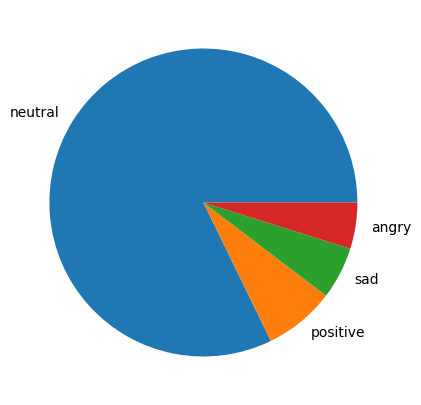

In [15]:
plt.figure(figsize=(10, 5))
plt.pie(emotions.values, labels = emotions.index)

### Присутствует сильный дисбаланс данных, нейтральных звуков на порядок больше

# Создадим числовое значение для каждой категории

In [16]:
le = LabelEncoder()

In [17]:
data["labels"] = le.fit_transform(data.emotion)
data.head()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,hash_id,wav_path,duration,emotion,new_path,labels
0,43efd890a85fc28fcc8548db10b90888,wavs/43efd890a85fc28fcc8548db10b90888.wav,1.6,neutral,/kaggle/input/mfk-dl-audio/data_train/data_tra...,1
1,da976ebe321ecbd80dca2d642a9e8a58,wavs/da976ebe321ecbd80dca2d642a9e8a58.wav,3.9,neutral,/kaggle/input/mfk-dl-audio/data_train/data_tra...,1
2,786cbd35237c638a2712c79b1d81bc00,wavs/786cbd35237c638a2712c79b1d81bc00.wav,3.7,neutral,/kaggle/input/mfk-dl-audio/data_train/data_tra...,1
3,96302eff7897e307f76dbbc75f7dada6,wavs/96302eff7897e307f76dbbc75f7dada6.wav,4.7,neutral,/kaggle/input/mfk-dl-audio/data_train/data_tra...,1
4,75bf42f881f336327fe70c4bae76936a,wavs/75bf42f881f336327fe70c4bae76936a.wav,3.7,positive,/kaggle/input/mfk-dl-audio/data_train/data_tra...,2


In [18]:
data.labels.value_counts()

labels
1    36997
2     3348
3     2470
0     2185
Name: count, dtype: int64

### Нам нужны только 2 этих столбца

In [19]:
final_data = data[["new_path","labels"]]
final_data.head()

,new_path,labels
0,/kaggle/input/mfk-dl-audio/data_train/data_tra...,1
1,/kaggle/input/mfk-dl-audio/data_train/data_tra...,1
2,/kaggle/input/mfk-dl-audio/data_train/data_tra...,1
3,/kaggle/input/mfk-dl-audio/data_train/data_tra...,1
4,/kaggle/input/mfk-dl-audio/data_train/data_tra...,2


# Изучим свойства аудио

Это не самый оптимальный способ, но мне нужно быстро изучить данные

In [20]:
sig, sr = torchaudio.load(final_data.new_path[0])
sig.shape, sr

(torch.Size([1, 25600]), 16000)

In [21]:
info = final_data.new_path.iloc[::42].map(torchaudio.load)

In [22]:
channel_num = info.map(lambda x: (x[0].shape)[0])
sample_rate = info.map(lambda x: x[1])

In [23]:
channel_num.value_counts()

new_path
1    1072
Name: count, dtype: int64

In [24]:
sample_rate.value_counts()

new_path
16000    1072
Name: count, dtype: int64

### Все аудио одноканальные (моно) с sample_rate 16000

# Создадим DataLoader

In [25]:
class SoundDS(Dataset):
  def __init__(self, df, train = True):
    self.df = df
    self.sr = 16000
    self.dur_in_sec = 4
    self.train = train
            
        
  def __len__(self):
    return len(self.df)    
    

  def __getitem__(self, idx):
    audio_file = self.df.loc[idx, 'new_path']
    if self.train:
        label = self.df.loc[idx, 'labels']
    else:
        label = -1
    
    
    tensor, _ = torchaudio.load(audio_file)

    tensor = self.resize(tensor)
    
    result = self.spectrogram(tensor)

    return result, label


  def resize(self, signal):
    max_len = self.sr * self.dur_in_sec
    signal_len = signal.shape[1]
    
    if (signal_len > max_len):
      signal = signal[:,:max_len]

    elif (signal_len < max_len):
      padding_begin_len = random.randint(0, max_len - signal_len)
      padding_end_len = max_len - signal_len - padding_begin_len

      padding_begin = torch.zeros((1, padding_begin_len))
      padding_end = torch.zeros((1, padding_end_len))

      signal = torch.cat((padding_begin, signal, padding_end), 1)
    return signal


  def spectrogram(self,signal, n_mels=64, n_fft=1024, hop_len=None):
    top_db = 80

    spectr = transforms.MelSpectrogram(self.sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(signal)

    # Convert to decibels
    spectr = transforms.AmplitudeToDB(top_db=top_db)(spectr)
    return (spectr)

In [26]:
dataset = SoundDS(final_data)

### размер тензора

In [27]:
dataset[0][0].shape

torch.Size([1, 64, 126])

### Получим картину звука

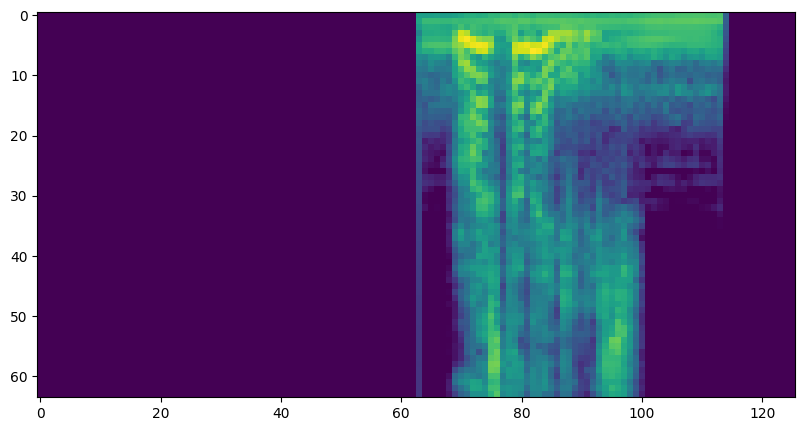

In [28]:
plt.figure(figsize=(10, 5))
plt.imshow(dataset[0][0][0].numpy())

### Длина аудио -- 1.6 секунд

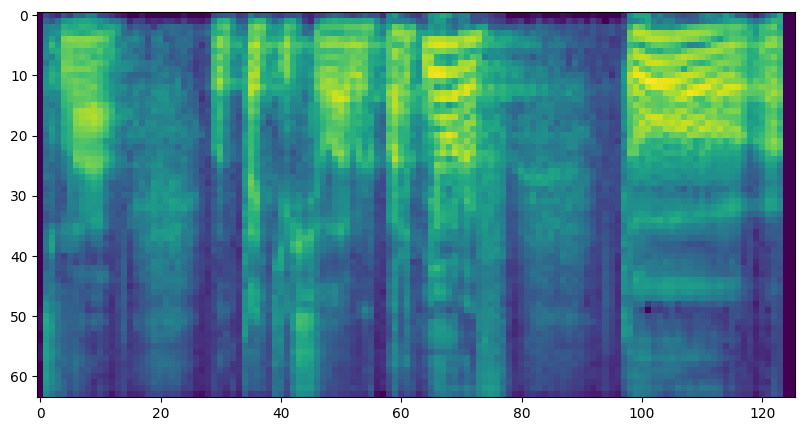

In [29]:
plt.figure(figsize=(10, 5))
plt.imshow(dataset[1][0][0].numpy())

### Длина аудио 3.9 секунд

# Далее с аудио можно обращаться, как с обычным изображением, поэтому обучим свёрточную сеть

### Возьмём 80% для обучения и 20% для тренировки

In [30]:
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

In [31]:
num_train

36000

In [32]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128, shuffle=False)

### Свёрточная нейросеть

In [33]:
class SimpleCnn(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        self.pool = nn.AdaptiveAvgPool2d((4,5))
        self.out = nn.Linear(128*4*5,4)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        #print(x.shape)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [34]:
from time import time

In [35]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):#,scheduler):
    X_val, Y_val = next(iter(data_val))
    history = {"train_loss": [], "val_loss": []}

    for epoch in tqdm(range(epochs)):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_train_loss = 0
        avg_val_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred,Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_train_loss += loss / len(data_tr)
        #scheduler.step()
        toc = time()
        #print('loss: %f' % avg_train_loss)
        history["train_loss"].append(avg_train_loss.detach().cpu().numpy())
        
        model.eval()  # testing mode
        for X_batch, Y_batch in data_val:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with torch.set_grad_enabled(False):
                # forward
                Y_pred = model(X_batch)
                loss = loss_fn(Y_pred,Y_batch) # forward-pass
            # calculate loss to show the user
            avg_val_loss += loss / len(data_val)
        print('loss: %f' % avg_val_loss)
        history["val_loss"].append(avg_val_loss.detach().cpu().numpy())
    return history

In [36]:
loss = nn.CrossEntropyLoss()

### обучаем на видеокарте

In [37]:
device = "cuda"

In [38]:
model = SimpleCnn().to(device)

In [39]:
max_epochs = 12
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
history = train(model, optimizer, loss, max_epochs, train_dl, val_dl)#, exp_lr_scheduler)

  0%|          | 0/12 [00:00<?, ?it/s]

* Epoch 1/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.562731
* Epoch 2/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.545266
* Epoch 3/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.528749
* Epoch 4/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.520474
* Epoch 5/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.514949
* Epoch 6/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.507580
* Epoch 7/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.509907
* Epoch 8/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.509387
* Epoch 9/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.495366
* Epoch 10/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.494128
* Epoch 11/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.490893
* Epoch 12/12


  0%|          | 0/71 [00:00<?, ?it/s]

loss: 0.482566


In [40]:
def draw_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"],label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

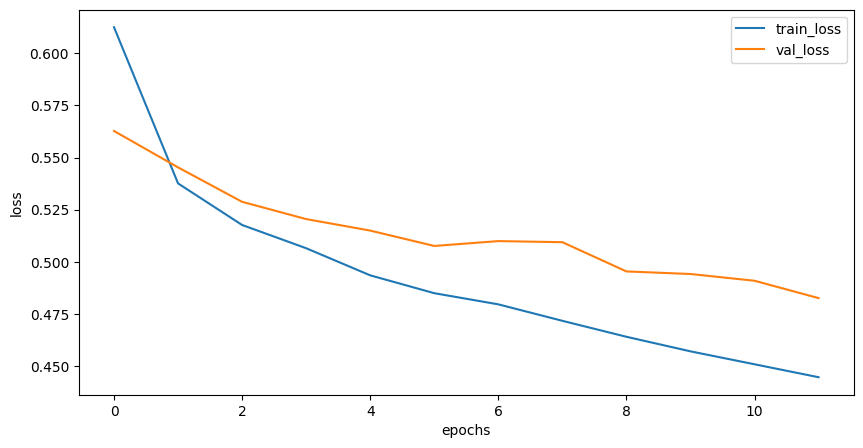

In [41]:
draw_history(history)

# Оценим модель на валидационной выборке

In [42]:
from sklearn.metrics import f1_score

In [43]:
def predict(model, data, device=device):
    preds_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, Y_batch in data:
            # data to device
            X_batch = X_batch.to(device)
            Y_pred = model(X_batch).cpu()
            probs = torch.nn.functional.softmax(Y_pred, dim=-1).numpy()
            preds_list.append(np.argmax(probs,-1))
    return np.hstack(preds_list)

In [44]:
def get_labels(model,data):
    labels_list =[]
    for X_batch, Y_batch in data:
        labels_list.append(Y_batch)
    return np.hstack(labels_list)

In [45]:
preds = predict(model,val_dl)

In [46]:
labels = get_labels(model,val_dl)

In [47]:
f1_score(labels, preds, average='macro')

0.4872218656459133

# Получим предсказания модели

In [48]:
test_data_path = os.path.join(root, 'data_test/data_test/manifest.tsv')
test_data_path

'/kaggle/input/mfk-dl-audio/data_test/data_test/manifest.tsv'

In [49]:
test_data = pd.read_csv(test_data_path)
test_data.head()

,hash_id,wav_path,duration
0,bc97a422e66c359e0018b216d15466d5,wavs/bc97a422e66c359e0018b216d15466d5.wav,3.1
1,a0ba5812c7228b493a32bea317e48119,wavs/a0ba5812c7228b493a32bea317e48119.wav,4.3
2,04c0d16bd592ab16acbc519d09e806bf,wavs/04c0d16bd592ab16acbc519d09e806bf.wav,1.7
3,2c676a530ab46bbd82e3f38a4459c2ce,wavs/2c676a530ab46bbd82e3f38a4459c2ce.wav,2.4
4,a519244bb791b089e3db97f615acd9db,wavs/a519244bb791b089e3db97f615acd9db.wav,2.5


In [50]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hash_id   3000 non-null   object 
 1   wav_path  3000 non-null   object 
 2   duration  3000 non-null   float64
dtypes: float64(1), object(2)
memory usage: 70.4+ KB


In [51]:
test_data["new_path"] = root + "/data_test/data_test/" + test_data.wav_path.astype(str)
test_data.new_path[0]

'/kaggle/input/mfk-dl-audio/data_test/data_test/wavs/bc97a422e66c359e0018b216d15466d5.wav'

In [52]:
test_data.head()

,hash_id,wav_path,duration,new_path
0,bc97a422e66c359e0018b216d15466d5,wavs/bc97a422e66c359e0018b216d15466d5.wav,3.1,/kaggle/input/mfk-dl-audio/data_test/data_test...
1,a0ba5812c7228b493a32bea317e48119,wavs/a0ba5812c7228b493a32bea317e48119.wav,4.3,/kaggle/input/mfk-dl-audio/data_test/data_test...
2,04c0d16bd592ab16acbc519d09e806bf,wavs/04c0d16bd592ab16acbc519d09e806bf.wav,1.7,/kaggle/input/mfk-dl-audio/data_test/data_test...
3,2c676a530ab46bbd82e3f38a4459c2ce,wavs/2c676a530ab46bbd82e3f38a4459c2ce.wav,2.4,/kaggle/input/mfk-dl-audio/data_test/data_test...
4,a519244bb791b089e3db97f615acd9db,wavs/a519244bb791b089e3db97f615acd9db.wav,2.5,/kaggle/input/mfk-dl-audio/data_test/data_test...


In [53]:
test_dataset = SoundDS(test_data, train = False)

In [54]:
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [55]:
preds = predict(model,test_dl)

### Преобразуем числовые значения обратно в строки

In [56]:
test_data["emotion"] = le.inverse_transform(preds)

In [57]:
test_data.head()

,hash_id,wav_path,duration,new_path,emotion
0,bc97a422e66c359e0018b216d15466d5,wavs/bc97a422e66c359e0018b216d15466d5.wav,3.1,/kaggle/input/mfk-dl-audio/data_test/data_test...,neutral
1,a0ba5812c7228b493a32bea317e48119,wavs/a0ba5812c7228b493a32bea317e48119.wav,4.3,/kaggle/input/mfk-dl-audio/data_test/data_test...,neutral
2,04c0d16bd592ab16acbc519d09e806bf,wavs/04c0d16bd592ab16acbc519d09e806bf.wav,1.7,/kaggle/input/mfk-dl-audio/data_test/data_test...,neutral
3,2c676a530ab46bbd82e3f38a4459c2ce,wavs/2c676a530ab46bbd82e3f38a4459c2ce.wav,2.4,/kaggle/input/mfk-dl-audio/data_test/data_test...,neutral
4,a519244bb791b089e3db97f615acd9db,wavs/a519244bb791b089e3db97f615acd9db.wav,2.5,/kaggle/input/mfk-dl-audio/data_test/data_test...,neutral


In [58]:
test_data.emotion.value_counts()

emotion
neutral     2695
sad          168
positive      95
angry         42
Name: count, dtype: int64

# Подготовим результат для отправки

In [59]:
submit = test_data[["hash_id","emotion"]]
submit

,hash_id,emotion
0,bc97a422e66c359e0018b216d15466d5,neutral
1,a0ba5812c7228b493a32bea317e48119,neutral
2,04c0d16bd592ab16acbc519d09e806bf,neutral
3,2c676a530ab46bbd82e3f38a4459c2ce,neutral
4,a519244bb791b089e3db97f615acd9db,neutral
...,...,...
2995,c8ee8f49455b0f71e1c161df493bf702,neutral
2996,a4fc93d2f3d630c0c57bd1b263a3b761,neutral
2997,aed211997ea397c0493f66a55a1199aa,neutral
2998,ab4cc71e0b40a90a52bda877acb697be,neutral


In [60]:
submit.to_csv('y_pred.csv', index=False)